In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.


## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

In [ ]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/toxic_comments.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
data.head(20)

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,9,alignment on this subject and which are contrary to those of DuLithgow,0


In [ ]:
data = data.drop('Unnamed: 0', axis = 1)

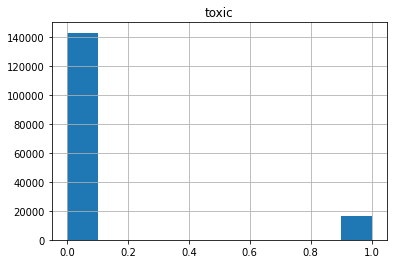

In [ ]:
data.hist();

In [ ]:
(data.loc[data['toxic'] == 1]).shape[0]/data.shape[0]*100

10.161213369158526

Наблюдается дисбаланс классов, предсказания моделей могут сильно отклоняться

In [ ]:
def get_wordnet_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {'J' : wordnet.ADJ,
              'N' : wordnet.NOUN,
              'V' : wordnet.VERB,
              'R' : wordnet.ADV}
  return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
  text = text.lower()
  lemm = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])
  text = re.sub(r'[^a-zA-Z ]', ' ', lemm)
  text = re.sub(r"(?:\n|\r)", " ", lemm)
  return ' '.join(text.split())

In [ ]:
data_mini = data[0:1000]

In [ ]:
%%time
data_mini['lemm_text'] = data_mini['text'].apply(lemmatize)

CPU times: user 11.9 s, sys: 733 ms, total: 12.6 s
Wall time: 12.8 s


In [ ]:
data_mini.head()

,text,toxic,lemm_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,"explanation why the edits make under my username hardcore metallica fan be revert ? they be n't vandalism , just closure on some gas after i vote at new york doll fac . and please do n't remove the template from the talk page since i 'm retire now.89.205.38.27"
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,"d'aww ! he match this background colour i 'm seemingly stuck with . thanks . ( talk ) 21:51 , january 11 , 2016 ( utc )"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,"hey man , i 'm really not try to edit war . it 's just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page . he seem to care more about the format than the actual info ."
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,"`` more i ca n't make any real suggestion on improvement - i wonder if the section statistic should be later on , or a subsection of `` '' type of accident '' '' -i think the reference may need tidy so that they be all in the exact same format ie date format etc . i can do that later on , if no-one else do first - if you have any preference for format style on reference or want to do it yourself please let me know . there appear to be a backlog on article for review so i guess there may be a delay until a reviewer turn up . it 's list in the relevant form eg wikipedia : good_article_nominations # transport ``"
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,"you , sir , be my hero . any chance you remember what page that 's on ?"


In [ ]:
%%time
data['lemm_text'] = data['text'].apply(lemmatize)

CPU times: user 27min, sys: 1min 42s, total: 28min 42s
Wall time: 28min 57s


## Обучение

In [ ]:
target = data['toxic']
features = data.drop('toxic', axis = 1 )

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle = True, stratify = target, test_size = 0.3, random_state = 88)

In [ ]:
print(data.shape)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(159292, 3)
(111504, 2)
(111504,)
(47788, 2)
(47788,)


In [ ]:
corpus_train = features_train['lemm_text']
corpus_test = features_test['lemm_text']

In [ ]:
stopwords = set(nltk_stopwords.words('english'))
stopwords = list(stopwords)
count_tf_idf = TfidfVectorizer(stop_words = stopwords)

In [ ]:
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_test = count_tf_idf.transform(corpus_test)

In [ ]:
print(tf_idf_train.shape)
print(tf_idf_test.shape)

(111504, 141570)
(47788, 141570)


In [ ]:
%%time
model = LogisticRegression(random_state = 88, solver = 'liblinear', class_weight = 'balanced', max_iter = 500)
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

grid_clf = GridSearchCV(model, parameters, cv = 5, scoring = 'f1')
grid_clf.fit(tf_idf_train, target_train)

print(grid_clf.best_estimator_)
print(grid_clf.best_params_)
print(grid_clf.best_score_)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=88,
                   solver='saga')
{'solver': 'saga'}
0.7378029531807578
CPU times: user 6min, sys: 1min 1s, total: 7min 1s
Wall time: 6min 15s


In [ ]:
%%time
forest_model = RandomForestClassifier(class_weight = 'balanced', random_state = 88)
parametrs = {'max_depth' : range(2, 10, 2),
            'n_estimators' : range(5, 65, 10)}
grid = GridSearchCV(forest_model, parametrs, scoring = 'f1', cv = 5)
grid.fit(tf_idf_train, target_train)

print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=55,
                       random_state=88)
{'max_depth': 8, 'n_estimators': 55}
0.3256485788317291
CPU times: user 9min 48s, sys: 2.38 s, total: 9min 50s
Wall time: 9min 54s


In [ ]:
%%time
light_model = LGBMClassifier(random_state = 88, is_unbalance = True)
light_params = {'n_estimators': [10,50,100],
               'max_depth': [15,30],
               'num_leaves': [10,20,31],
               'learning_rate': [0.1]}
light_cv = GridSearchCV(light_model,
                             light_params,
                             cv = 5,
                             scoring = 'f1',
                             verbose = False,
                             error_score = 'raise')

light_cv.fit(tf_idf_train, target_train)

print(light_cv.best_estimator_)
print(light_cv.best_params_)
print(light_cv.best_score_)

LGBMClassifier(is_unbalance=True, max_depth=15, random_state=88)
{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100, 'num_leaves': 31}
0.7283371597902532
CPU times: user 59min 45s, sys: 15.3 s, total: 1h 1s
Wall time: 35min 36s


In [ ]:
model = LogisticRegression(random_state = 88, solver = 'saga', class_weight = 'balanced', max_iter = 500)
model.fit(tf_idf_train, target_train)
predict = model.predict(tf_idf_test)
print('F1_score:', f1_score(target_test, predict))

F1_score: 0.7490569426980419


Наилучшей моделью оказалась логистическая регрессия со сбалансированными классами.

## Выводы

Обработали входные данные: очистили текст от символов переходов на новую строку, стоп-слов и провели лемматизацию.
Рассмотрели несколько моделей, выбрали с наилучшим значением.

